In [1]:
%cd ..

/nfs/scistore16/edelgrp/fzimin/depth-poset


/mnt/nfs/clustersw/Debian/bookworm/jupyterhub/1.0/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import os

import numpy as np
import pandas as pd
import pickle as pkl
import networkx as nx
import gudhi as gh
import pickle as pkl

from src.depth import DepthPoset


#from tqdm.notebook import tqdm
from tqdm import tqdm

from matplotlib import pyplot as plt
from matplotlib import cm
from networkx import draw_networkx
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib import lines as mlines

from src.depth import DepthPoset


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/mnt/nfs/clustersw/Debian/bookworm/jupyterhub/1.0/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/mnt/nfs/clustersw/Debian/bookworm/jupyterhub/1.0/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/mnt/nfs/clustersw/Debian/bookworm/jupyterhub/1.0/lib/python3.11/site-packages/ipykern

AttributeError: _ARRAY_API not found

# Load and Format the Data

In [3]:
directory = "results/transpositions-during-linear-homotopy-between-barycentric-cubical-toruses"
paths = np.sort([f'{directory}/{f}' for f in os.listdir(directory)])

In [4]:
def get_dim_and_n_from_torus_file(path):
    with open(path, 'rb') as file:
        res = pkl.load(file)
    return res['dim'], res['n']

/tmp/ipykernel_3340412/4026766541.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_sizes[['original_path0', 'original_path1']] = df_sizes[['original_path0', 'original_path1']].applymap(lambda path: f'results/scores-on-barycentric-cubical-toruses/{path}.pkl')
Extracting the Dimensions and sizes of toruses: 100%|██████████| 1529/1529 [00:00<00:00, 1536.01it/s]


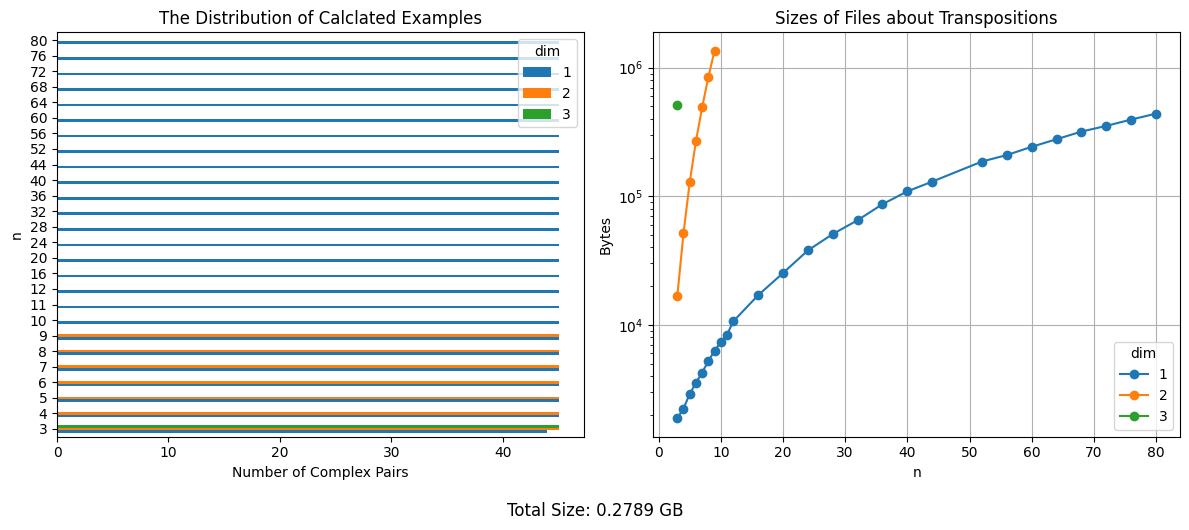

In [5]:
df_sizes = pd.DataFrame({'path': paths})
df_sizes['size'] = df_sizes['path'].apply(lambda path: os.path.getsize(path))
df_sizes['original_path0'] = df_sizes['path'].apply(lambda path: os.path.splitext(os.path.basename(path))[0].split(' and ')[0])
df_sizes['original_path1'] = df_sizes['path'].apply(lambda path: os.path.splitext(os.path.basename(path))[0].split(' and ')[1])
df_sizes[['original_path0', 'original_path1']] = df_sizes[['original_path0', 'original_path1']].applymap(lambda path: f'results/scores-on-barycentric-cubical-toruses/{path}.pkl')
df_sizes['original_size0'] = df_sizes['original_path0'].apply(lambda path: os.path.getsize(path))
df_sizes['original_size1'] = df_sizes['original_path1'].apply(lambda path: os.path.getsize(path))
tqdm.pandas(desc='Extracting the Dimensions and sizes of toruses')
df_sizes['dim&n'] = df_sizes['original_path0'].progress_apply(lambda path: get_dim_and_n_from_torus_file(path))
df_sizes['dim'] = df_sizes['dim&n'].apply(lambda dimn: dimn[0])
df_sizes['n'] = df_sizes['dim&n'].apply(lambda dimn: dimn[1])
df_sizes = df_sizes.drop(columns='dim&n')


fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].set_title('The Distribution of Calclated Examples')
df_sizes.groupby(['dim', 'n'])['path'].count().reset_index().pivot_table(columns='dim', index='n', values='path').fillna(0).astype(int).plot(kind='barh', ax=axs[0])
axs[0].set_xlabel('Number of Complex Pairs')

axs[1].set_title('Sizes of Files about Transpositions')
df_sizes.groupby(['dim', 'n'])['size'].mean().reset_index().pivot_table(columns='dim', index='n', values='size').plot(logy=True, marker='o', ax=axs[1])
axs[1].set_ylabel('Bytes')
axs[1].grid(True)

fig.text(0.5, -0.05, f"Total Size: {df_sizes['size'].sum()*1024**-3:.4f} GB", ha='center', va='bottom', fontsize='large')
plt.tight_layout()
plt.show()

In [6]:
df = []
errs = {}
for path in tqdm(paths):
    if os.path.getsize(path) < np.inf*1024**2:
        try:
            with open(path, 'rb') as file:
                loaded_dict = pkl.load(file)
            loaded_dict['transpositions'].insert(0, 'complex_index0', loaded_dict['complex_index0'])
            loaded_dict['transpositions'].insert(1, 'complex_index1', loaded_dict['complex_index1'])
            loaded_dict['transpositions'].insert(2, 'complex_dim', loaded_dict['complex_dim'])
            loaded_dict['transpositions'].insert(3, 'complex_shape', [loaded_dict['complex_shape']]*len(loaded_dict['transpositions']))
            df.append(loaded_dict['transpositions'])

        except Exception as err:
            errs.update({path: err})
    else:
        errs.update({path: 'Giant file'})
errs = pd.Series(errs)
if len(errs) > 0:
    errs_count = errs.astype(str).value_counts()
    print(f'There is some amount of errors:\n{errs_count.to_string(name=False)}\n')
    #for path in errs.index:
    #    if os.path.exists(path):
    #        os.remove(path)
    
df = pd.concat(df)

if not 'complex_n' in df.columns: 
    df.insert(3, 'complex_n', df['complex_shape'].apply(lambda x: x[0] if (np.array(x)[1:] == np.array(x)[:-1]).all() else None))

#print(f'There are {pd.isna(df['transposition']).sum()} empty transposition values in {len(df)} lines')
#df = df[~pd.isna(df['transposition'])]
#df = df.join(df['transposition'].apply(lambda tr: tr.to_dict()).apply(pd.Series))

print(f'df.shape = {df.shape}')
df.head()

100%|██████████| 1529/1529 [00:02<00:00, 564.96it/s]


df.shape = (2155923, 24)


,complex_index0,complex_index1,complex_dim,complex_n,complex_shape,time,value,birth_relation_cell_similarity,birth_relation_index_similarity,death_relation_cell_similarity,...,poset_node_index_similarity,relation_cell_similarity,relation_index_similarity,index 0,index 1,cell 0,cell 1,dim,type,switch
0,2025-06-18 16:08:54.761551,2025-06-18 16:08:54.771944,1,4,"(4,)",0.001931,0.431932,1.0,1.0,1.0,...,0.2,1.0,1.0,1,2,"((0,),)","((2,),)",0,birth-birth,no switch
1,2025-06-18 16:08:54.761551,2025-06-18 16:08:54.771944,1,4,"(4,)",0.022655,0.430177,1.0,1.0,1.0,...,1.0,1.0,1.0,0,1,"((1,),)","((2,),)",0,birth-unpaired,undefined
2,2025-06-18 16:08:54.761551,2025-06-18 16:08:54.771944,1,4,"(4,)",0.429125,1.571011,0.0,0.0,1.0,...,0.2,0.0,0.0,5,6,"((0,), (1,))","((3,), (0,))",1,death-death,no switch
3,2025-06-18 16:08:54.761551,2025-06-18 16:08:54.771944,1,4,"(4,)",0.719007,1.746056,0.0,1.0,0.0,...,1.0,0.0,1.0,6,7,"((0,), (1,))","((2,), (3,))",1,death-unpaired,undefined
4,2025-06-18 16:08:54.761551,2025-06-18 16:08:54.771944,1,4,"(4,)",0.856378,0.898951,0.0,1.0,0.0,...,1.0,0.0,1.0,2,3,"((0,),)","((3,),)",0,birth-birth,switch backward


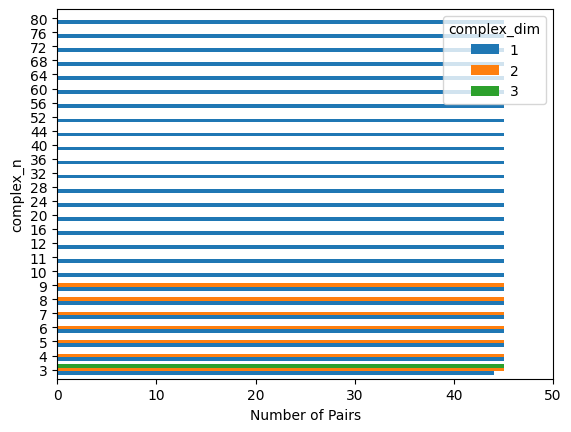

In [7]:
df.groupby(['complex_index0', 'complex_index1', 'complex_dim', 'complex_n']
           )['index 0'].count().reset_index().groupby(['complex_dim', 'complex_n']
            )['complex_index0'].count().reset_index().pivot_table(columns='complex_dim', index='complex_n', values='complex_index0').fillna(0).astype(int).plot(kind='barh', width=0.8)

plt.xlabel('Number of Pairs')
xticks, _ = plt.xticks()
xticks = np.unique(np.array(xticks).astype(int))
plt.xticks(xticks)

plt.show()

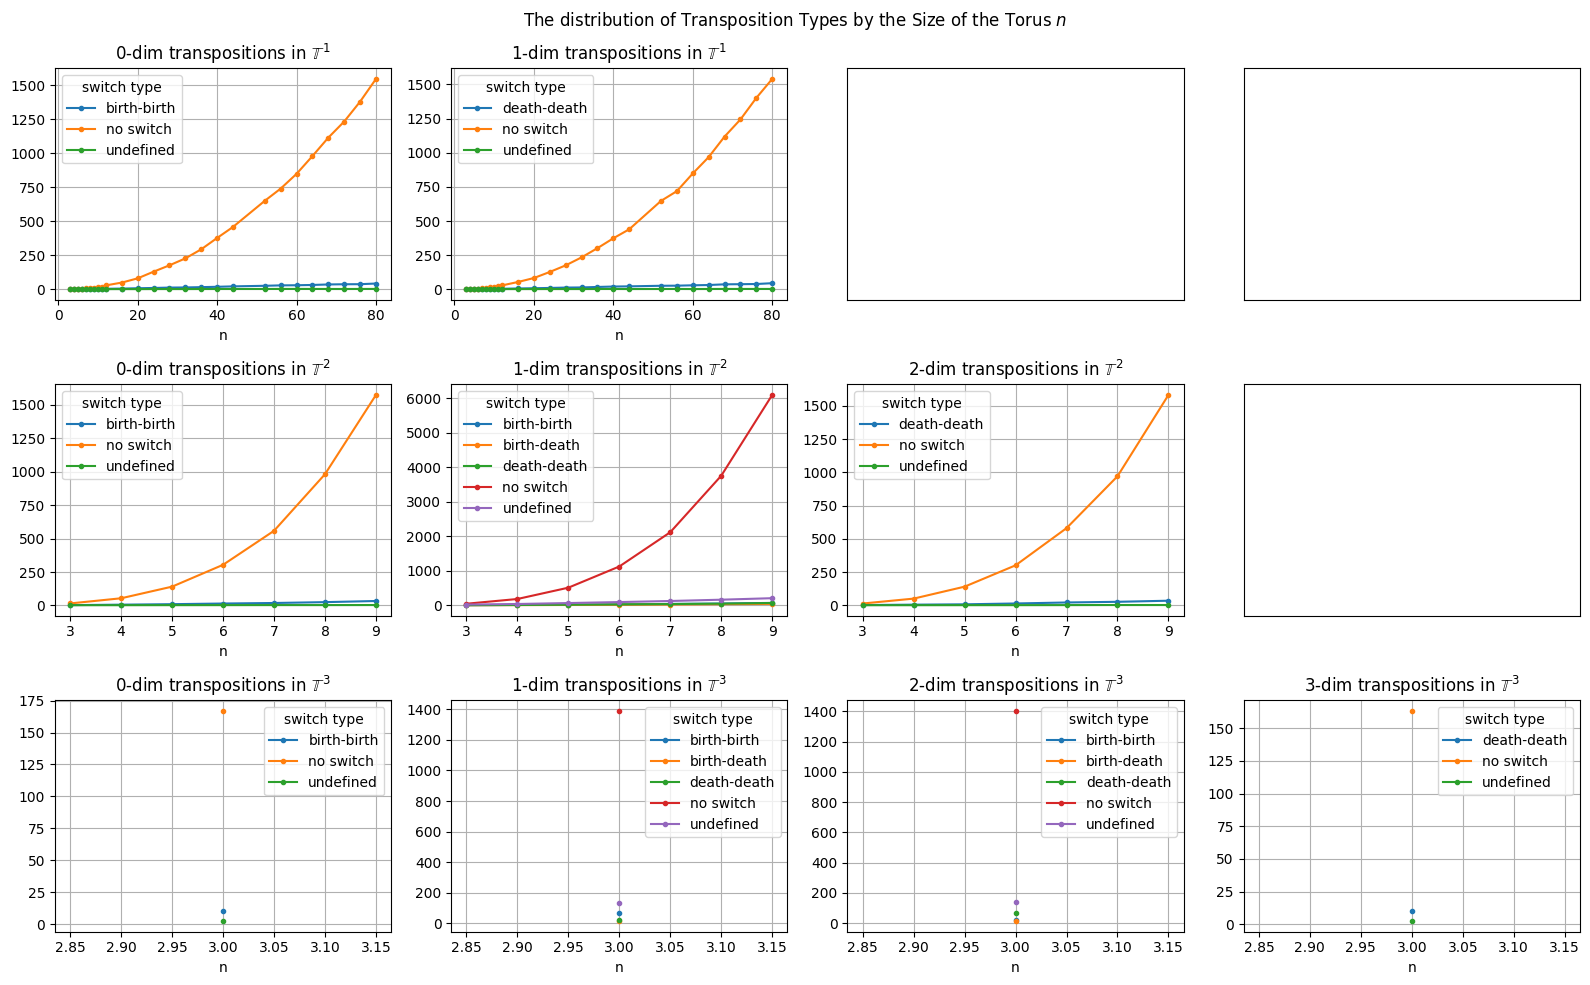

In [8]:
df_switch_types = df.copy()

df_switch_types.loc[(df_switch_types['switch'] == 'switch forward') | (df_switch_types['switch'] == 'switch backward'), 'switch'] = 'switch'
df_switch_types['switch type'] = df_switch_types.apply(lambda row: row['type'] if row['switch'] == 'switch' else row['switch'], axis=1)

df_switch_types = df_switch_types.groupby(['complex_index0', 'complex_index1', 'complex_dim', 'complex_n', 'dim', 'switch type'])['index 0'].count().reset_index().rename(columns={'index 0': 'count'})
df_switch_types = df_switch_types.groupby(['complex_dim', 'complex_n', 'dim', 'switch type'])['count'].mean().reset_index()
df_switch_types = df_switch_types.pivot_table(index='complex_n', columns=['complex_dim', 'dim', 'switch type'], values='count')

complex_dims = pd.unique(df['complex_dim'])
transposition_dims = pd.unique(df['dim'])

fig, axs = plt.subplots(len(complex_dims), len(transposition_dims), figsize=(4*len(transposition_dims), 3*len(complex_dims) + 1), squeeze=False)
fig.suptitle('The distribution of Transposition Types by the Size of the Torus $n$')
for i, complex_dim in enumerate(complex_dims):
    for j, transposition_dim in enumerate(transposition_dims):
        try:
            df_switch_types[complex_dim][transposition_dim].plot(ax=axs[i, j], marker='.')
            axs[i, j].set_title(f'{transposition_dim}-dim transpositions in $\\mathbb{{T}}^{{\;{complex_dim}}}$')
            axs[i, j].grid(True)
            axs[i, j].set_xlabel('n')
        except KeyError:
            axs[i, j].set_xticks([])
            axs[i, j].set_yticks([])
plt.tight_layout()


In [9]:
df[['dim', 'type', 'switch']].value_counts().reset_index().pivot_table(columns=['dim', 'switch'], index='type', values='count').fillna(0).astype(int)

dim                       0                                           \
switch            no switch switch backward switch forward undefined   
type                                                                   
birth-birth          637990           11457          11811         0   
birth-death               0               0              0         0   
birth-unpaired            0               0              0      3120   
death-death               0               0              0         0   
death-unpaired            0               0              0         0   
unpaired-unpaired         0               0              0         0   

dim                       1                                           \
switch            no switch switch backward switch forward undefined   
type                                                                   
birth-birth          302025            6368           6433         0   
birth-death          114318               0           6419         0   
birth-unpaired            0               0              0     17185   
death-death          735556           13934          14481         0   
death-unpaired            0               0              0     21812   
unpaired-unpaired         0               0              0      1241   

dim                       2                                           \
switch            no switch switch backward switch forward undefined   
type                                                                   
birth-birth           13611             501            532         0   
birth-death            6433               0            613         0   
birth-unpaired            0               0              0      3268   
death-death          206909            4077           4264         0   
death-unpaired            0               0              0      3259   
unpaired-unpaired         0               0              0       412   

dim                       3                                           
switch            no switch switch backward switch forward undefined  
type                                                                  
birth-birth               0               0              0         0  
birth-death               0               0              0         0  
birth-unpaired            0               0              0         0  
death-death            7342             212            239         0  
death-unpaired            0               0              0       101  
unpaired-unpaired         0               0              0         0

In [10]:
df[df['switch'] == 'undefined'][['dim', 'type']].value_counts().reset_index().pivot_table(index='type', columns='dim', values='count').fillna(0).astype(int)

dim,0,1,2,3
type,,,,
birth-unpaired,3120,17185,3268,0
death-unpaired,0,21812,3259,101
unpaired-unpaired,0,1241,412,0
